In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import math
import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter
num_samples = 50 # Data set size
x_dim = 4 # dimension
sigma_a = 3.0 ** 2
sigma_eps = 1.0 ** 2 # variance of noise
k_inf = 5 # take to be large for a good approximation to the IBP
pi_true, z_true, mu_true, a_true, x = vi.generate_data(num_samples, x_dim, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, x_dim, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(x, k_approx, alpha, sigma_eps, sigma_a)

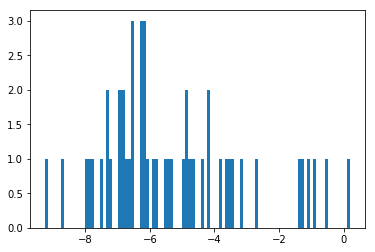

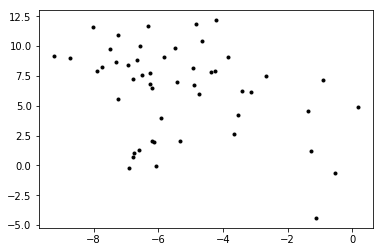

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
z = z_true.astype(float, copy=True)
a = deepcopy(a_true.T)
pi = deepcopy(pi_true)

ll = vi.exp_log_likelihood(z, a, a**2, np.log(pi), np.log(1 - pi), sigma_a, sigma_eps, x, alpha)

In [5]:
class GibbsSampler(object):
    def __init__(self, x, k_approx, alpha, sigma_eps, sigma_a):
        self.x = x
        self.x_n = x.shape[0]
        self.x_d = x.shape[1]
        self.k_approx = k_approx
        self.alpha = alpha
        self.sigma_eps = sigma_eps
        self.sigma_a = sigma_a
        
        self.get_z_cond_params = grad(self.z_lp, argnum=0)
        self.get_a_cond_params = grad(self.a_lp, argnum=0)
        self.get_a2_cond_params = grad(self.a_lp, argnum=1)
        self.get_pi1_cond_params = grad(self.pi_lp, argnum=0)
        self.get_pi2_cond_params = grad(self.pi_lp, argnum=1)

        self.initialize_sampler()
        
    def z_lp(self, z):
        return vi.exp_log_likelihood(
            z, self.a, self.a**2, np.log(self.pi), np.log(1 - self.pi),
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def pi_lp(self, logpi, log1mpi):
        return vi.exp_log_likelihood(
            self.z, self.a, self.a**2, logpi, log1mpi,
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def a_lp(self, a, a2):
        return vi.exp_log_likelihood(
            self.z, a, a2, np.log(self.pi), np.log(1 - self.pi),
            self.sigma_a, self.sigma_eps, self.x, self.alpha)

    def initialize_sampler(self):
        # Initial values for draws
        self.pi = np.ones(k_approx) * .8
        self.z = np.random.binomial(1, pi, [ self.x_n, k_approx ]).astype(float, copy=True)
        self.a = np.random.normal(0, np.sqrt(sigma_a), (self.x_d, k_approx))

        self.pi_draws = []
        self.z_draws = []
        self.a_draws = []
        
    def draw_z_column(self, k):
        # Because the z columns are inter-dependent, only draw one column at a time.
        assert k < self.k_approx
        z_cond_params = self.get_z_cond_params(self.z)
        z_logsumexp = sp.misc.logsumexp(z_cond_params, 1)
        z_means = np.exp(z_cond_params - np.broadcast_to(z_logsumexp, (k_approx, num_samples)).T)
        z[:, k] = vi.draw_z(z_means, 1)[0, :, k].astype(float)
        
    def draw_a(self):
        a_cond_params = self.get_a_cond_params(self.a, self.a**2)
        a2_cond_params = self.get_a2_cond_params(self.a, self.a**2)

        a_var = -0.5 / a2_cond_params
        a_mean = a_var * a_cond_params
        assert np.all(a_var > 0)

        a = vi.draw_a(a_mean, a_var, 1)[0, :, :]

    def draw_pi(self):
        pi1_cond_params = self.get_pi1_cond_params(np.log(self.pi), np.log(1 - self.pi))
        pi2_cond_params = self.get_pi2_cond_params(np.log(self.pi), np.log(1 - self.pi))

        # Note -- add one to get the beta distribution parameters from the gradients.
        pi_params = np.vstack([pi1_cond_params, pi2_cond_params]).T + 1
        pi = vi.draw_pi(pi_params, 1)[0, :]
        
        
    def draw(self):
        # Draw the z columns in a random order.
        self.draw_a()
        self.draw_pi()
        for z_col in np.random.permutation(self.k_approx):
            self.draw_z_column(z_col)
                
        self.a_draws.append(self.a)
        self.pi_draws.append(self.pi)
        self.z_draws.append(self.z)
        
    

In [6]:
gibbs_sampler = GibbsSampler(x, k_approx, alpha, sigma_eps, sigma_a)

num_gibbs_draws = 10
for n in range(num_gibbs_draws):
    gibbs_sampler.draw()